<a href="https://colab.research.google.com/github/pingwx/ya.prac/blob/main/13_ML_for_texts/additional_BERT_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install transformers

In [ ]:
#!pip install catboost

#BERT EXAMPLE

In [3]:
import numpy as np
import pandas as pd
import torch
import re
from tqdm import notebook
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from transformers import AutoTokenizer, AutoModel
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt

## Загрузка комменатриев

In [4]:
URL = # path to your dataset
BATCH_SIZE = 100

In [5]:
df_tweets = pd.read_csv(URL)
df_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [6]:
df_tweets.sample(n=10, random_state=12345)

,text,toxic
146790,Ahh shut the fuck up you douchebag sand nigger...,1
2941,"""\n\nREPLY: There is no such thing as Texas Co...",0
115087,"Reply\nHey, you could at least mention Jasenov...",0
48830,"Thats fine, there is no deadline ) chi?",0
136034,"""\n\nDYK nomination of Mustarabim\n Hello! You...",0
121992,"""\n\nSockpuppetry case\n \nYou have been accus...",0
37282,"Judging by what I've just read in an article, ...",0
64488,Todd and Copper\nIn the first film they were l...,0
16992,"""\n\n \nYou have been blocked from editing for...",0
138230,| decline=Can't find evidence of block either ...,0


In [7]:
df_tweets['toxic'].value_counts()

0    143346
1     16225
Name: toxic, dtype: int64

Сделаем колличество коментариев кратным BATCH_SIZE (отбросим остаток)

In [8]:
sample_tweets = df_tweets.sample(n=len(df_tweets)//BATCH_SIZE*BATCH_SIZE, random_state=12345)

In [9]:
sample_tweets.shape

(159500, 2)

## Чистка

In [10]:
def clear_text(text):
  text = re.sub(r'[^a-zA-Z ]', ' ', text)
  return ' '.join(text.split())

In [11]:
corpus = sample_tweets['text'].values.astype('U')
clean_corpus = []
for i in corpus:
  clean_corpus.append(clear_text(i))
sample_tweets['text_clean'] = clean_corpus

##Загрузка предобученной модели (пробовали разные: маленькие и большие)
Update: нашли модель, обученную под нашу задачу

In [12]:
tokenizer = AutoTokenizer.from_pretrained("unitary/toxic-bert")
model = AutoModel.from_pretrained("unitary/toxic-bert")

Downloading:   0%|          | 0.00/174 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/811 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/418M [00:00<?, ?B/s]

Some weights of the model checkpoint at unitary/toxic-bert were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Токенизация

In [14]:
# Эта ячейка взята из тренажера
tokenized = sample_tweets['text_clean'].apply(
    lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=512, truncation=True))
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)
padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])
attention_mask = np.where(padded != 0, 1, 0)

Колаб отрубает GPU часто

In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [16]:
model.to(device)
f'Moved model on {device} device'

'Moved model on cuda device'

## Делаем эмбеддинги предобученной моделью

In [17]:
# И эта ячейка из тренажера
embeddings = []
for i in notebook.tqdm(range(padded.shape[0] // BATCH_SIZE)):
  batch = torch.LongTensor(padded[BATCH_SIZE*i:BATCH_SIZE*(i+1)]) 
  attention_mask_batch = torch.LongTensor(attention_mask[BATCH_SIZE*i:BATCH_SIZE*(i+1)])      
  with torch.no_grad():
    batch = batch.to(device)
    attention_mask_batch = attention_mask_batch.to(device)
    batch_embeddings = model(batch, attention_mask=attention_mask_batch)        
    embeddings.append(batch_embeddings[0][:,0,:].cpu().numpy())

  0%|          | 0/1595 [00:00<?, ?it/s]

## Делим на трейн, валид, тест

In [18]:
features = np.concatenate(embeddings)

In [19]:
target = sample_tweets['toxic'].values

In [20]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=12345)

In [21]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=12345)

In [22]:
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((95700, 768), (31900, 768), (31900, 768), (95700,), (31900,), (31900,))

## Функция для вычисления threshold

In [23]:
def get_best_threshold(y_val, proba):
  fpr, tpr, thresholds = roc_curve(y_val, proba)
  plt.figure(figsize=(9, 9))
  plt.plot(fpr, tpr)
  plt.plot([0, 1], [0, 1], linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.0])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC-кривая')
  plt.show()
  best_f1 = 0
  best_thresh = 0
  for threshold in thresholds:
    predict = proba > threshold 
    f1 = f1_score(y_val, predict)
    if f1 > best_f1:
      best_f1 = f1
      best_thresh = threshold
  print('best threshold:', best_thresh)
  return best_thresh

## Классификаторы

Learning rate set to 0.072241
0:	learn: 0.5106057	total: 465ms	remaining: 7m 44s
100:	learn: 0.0346779	total: 32.7s	remaining: 4m 50s
200:	learn: 0.0290843	total: 1m 3s	remaining: 4m 14s
300:	learn: 0.0247390	total: 1m 37s	remaining: 3m 46s
400:	learn: 0.0215951	total: 2m 8s	remaining: 3m 12s
500:	learn: 0.0193181	total: 2m 39s	remaining: 2m 38s
600:	learn: 0.0172226	total: 3m 16s	remaining: 2m 10s
700:	learn: 0.0153781	total: 3m 47s	remaining: 1m 37s
800:	learn: 0.0136885	total: 4m 18s	remaining: 1m 4s
900:	learn: 0.0123656	total: 4m 49s	remaining: 31.8s
999:	learn: 0.0111437	total: 5m 20s	remaining: 0us


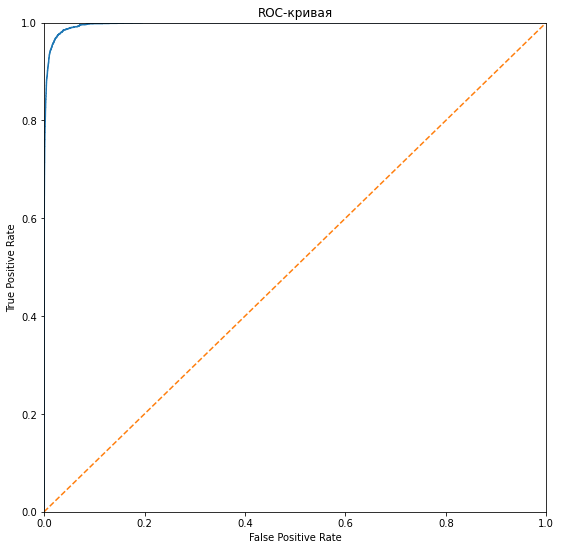

best threshold: 0.37741872737643267


0.9212102595607434

In [24]:
clf = CatBoostClassifier(random_state=12345)
clf.fit(X_train, y_train, verbose=100)
proba = clf.predict_proba(X_val)[:, 1]
thresh = get_best_threshold(y_val, proba)
predict = proba > thresh
f1 = f1_score(y_val, predict)
f1

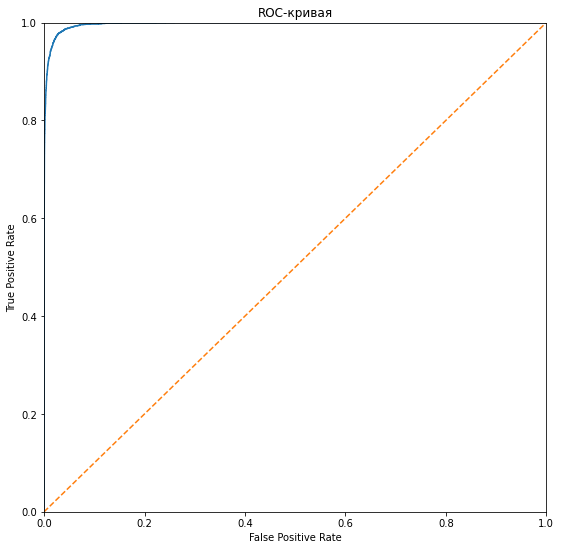

best threshold: 0.5279893284503975


0.9224952741020793

In [25]:
clf = LogisticRegression(max_iter=2000)
clf.fit(X_train, y_train)
proba = clf.predict_proba(X_val)[:, 1]
thresh = get_best_threshold(y_val, proba)
predict = proba > thresh
f1 = f1_score(y_val, predict)
f1

##Тест

Качество у классификаторов похожее, тестируем последний

In [26]:
proba = clf.predict_proba(X_test)[:, 1]
predict = proba > thresh
f1 = f1_score(y_test, predict)
f1

0.9163625304136254

## Вывод

Значение метрики хуже, чем если делать в лоб методами sklearn, как улучшить - пока непонятно

Update: всего-то надо было модель нужную взять